# This notebook is used to transform FOVs to exvivo 
**Following steps are used**

0. load all data
1. FOV find matching to invivo on XY planes by 2D registration (using phase correlation) 
2. FOV find matching to invivo on Z axis by 3D registration (using previous step XY as the initialization, and using polar transformation to find the scaling and angles) --> Get `T(FOV)`
3. Load `T(in->ex)` and apply this to `T(FOV)`, which gives `T'(FOV)` --> this ought to be the FOVs that map to exvivos. 


after step1, we run a for loop to go ove each FOV and step 2 and 3 are applied for each FOV, the results are saved, and the next FOV is run. 

In [1]:
from datetime import date
import tifffile
import os, glob, sys
import pprint
import numpy as np
np.set_printoptions(suppress=True)
import pickle
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import math
from pprint import pprint
from PIL import Image

# for the angle and scaling (should not have the scaling difference though)
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
import simplemocor  # utility code from the local
import tqdm


sys.path.append('./functions/')
import transformations


# 0.1 load invivo tomato 
- we used 2 times downsampled version `2xds` and it works fie
- but note that sometimes we have to cut the top and/or bottom of the z-axis to reduce some uncertainty... 


In [3]:
file_path = '/path_to_invivo_2xds_data.pkl'
invivo_tomato = pickle.load(open(file_path, 'rb'))[1]
print(invivo_tomato.shape)
invivo_tomato.shape
invivo_tomato[invivo_tomato<0]=0

(269, 784, 733)


In [4]:
invivo_tomato.shape

(269, 784, 733)

### cut out some useless z portion

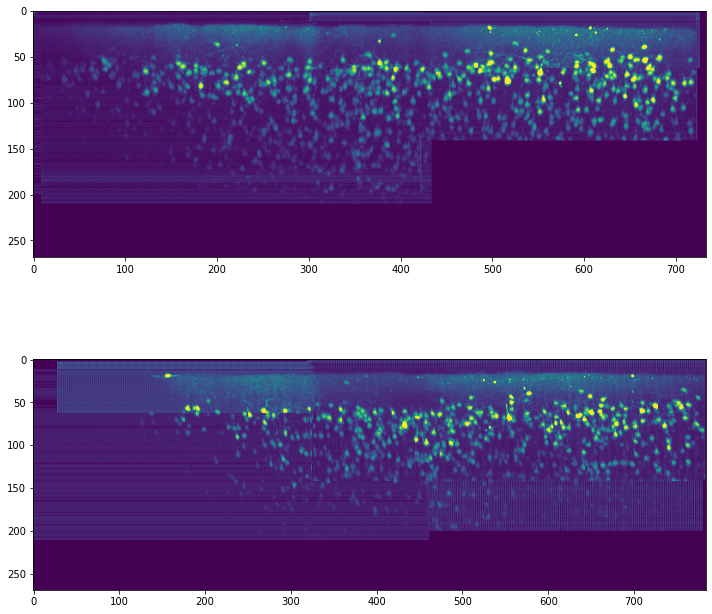

In [5]:
plt.figure(figsize = (10,10));
plt.subplot(2,1,1);plt.imshow(np.max(invivo_tomato, 1),vmax = invivo_tomato.max()*.3)
plt.subplot(2,1,2);plt.imshow(np.max(invivo_tomato, 2),vmax = invivo_tomato.max()*.3)
plt.tight_layout()

**define which part of invivo to use for 2D registration**

In [6]:
img1 = np.max(invivo_tomato[50:],0)

## 0.2. load ALL FOVs

In [7]:
f_dir_root_fov = '/path_to_averaged_FOV/'
filenames = glob.glob(f_dir_root_fov+'*.tif')
pprint(filenames)

['/home/ubuntu/largevolume2/massimo_xinxin/data/G130/averaged_FOV/Stacked_ch2_movie_FOV9_zstack_1100nm_3x_.tif',
 '/home/ubuntu/largevolume2/massimo_xinxin/data/G130/averaged_FOV/Stacked_ch2_movie_FOV10_zstack_1100nm_3x.tif',
 '/home/ubuntu/largevolume2/massimo_xinxin/data/G130/averaged_FOV/Stacked_ch2_movie_FOV3_4_zstack_1100nm_3x_.tif',
 '/home/ubuntu/largevolume2/massimo_xinxin/data/G130/averaged_FOV/Stacked_ch2_movie_FOV11_12_zstack_1100nm_3x_.tif',
 '/home/ubuntu/largevolume2/massimo_xinxin/data/G130/averaged_FOV/Stacked_ch2_movie_FOV13_14_zstack_1100nm_3x_.tif',
 '/home/ubuntu/largevolume2/massimo_xinxin/data/G130/averaged_FOV/Stacked_ch2_movie_FOV1_2_zstack_1100nm_3x_.tif']


In [8]:
len(filenames)

6

### optional steps
**problem:**
> we take only the even or odd frames from Stacked_ch2_movie_FOV1_2_zstack_1100nm_3x_ and Stacked_ch2_movie_FOV3_4_zstack_1100nm_3x_

so we keep them as `moreframefovs`

In [9]:
filenames = [f.split('/')[-1] for f in glob.glob(f_dir_root_fov+'*.tif')]
moreframefovs = [filenames[2],filenames[5]]
filenames = [f.split('/')[-1] for f in glob.glob(f_dir_root_fov+'*.tif')]
for i in range(len(filenames)):    
    if filenames[i] in moreframefovs:
        print(filenames[i])

Stacked_ch2_movie_FOV3_4_zstack_1100nm_3x_.tif
Stacked_ch2_movie_FOV1_2_zstack_1100nm_3x_.tif


## 0.3 load transformed results (to map invivo to exvivo) 
- this is your output from this notebook `invivo_to_exvivo.ipynb`

In [13]:
transformed_rez_path = '/path_to_results_of_transformed_rez_from_invivo_to_exvivo.pkl'
T_in_ex = pickle.load(open(transformed_rez_path, 'rb'))
T_in_ex.keys()

dict_keys(['transformed', 'transformations', 'pcd_invivo', 'pcd_exvivo'])

# 1. FOV to invivo at 2D case
- check if we can get teh 2D right (used as the initialization)!
- make sure the output looks reasonable. 

loading file: `Stacked_ch2_movie_FOV9_zstack_1100nm_3x_.tif`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV10_zstack_1100nm_3x.tif`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV3_4_zstack_1100nm_3x_.tif`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV11_12_zstack_1100nm_3x_.tif`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV13_14_zstack_1100nm_3x_.tif`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV1_2_zstack_1100nm_3x_.tif`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


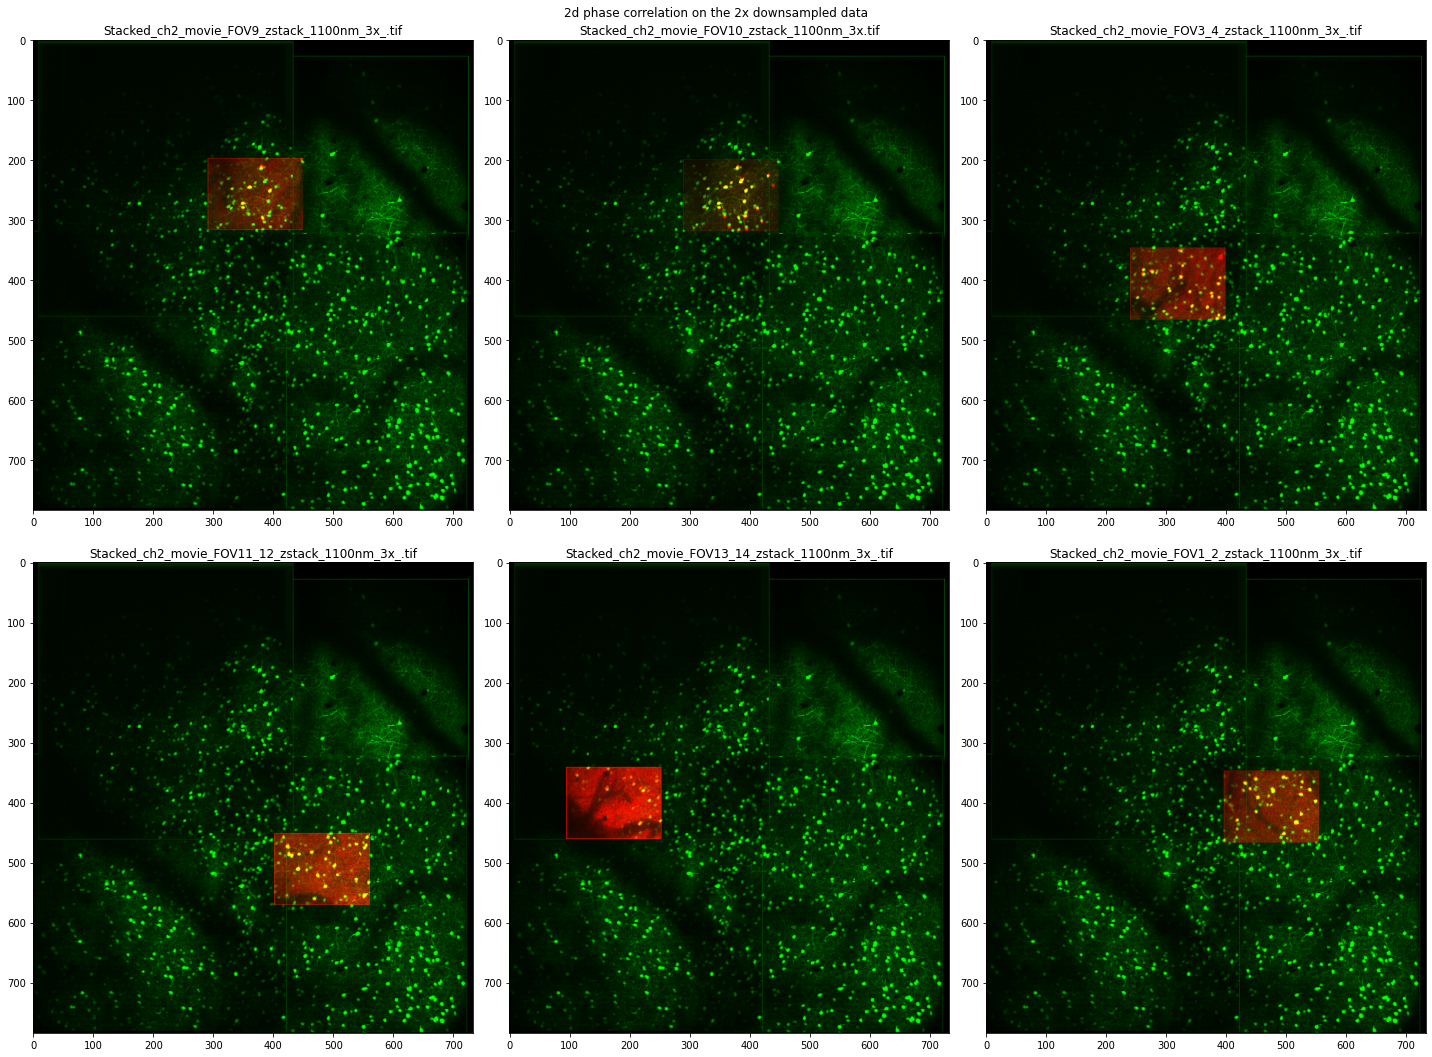

In [11]:
c = 0
plt.figure(figsize = (20,15))
plt.suptitle('2d phase correlation on the 2x downsampled data')
filenames = [f.split('/')[-1] for f in glob.glob(f_dir_root_fov+'*.tif')]
for i in range(len(filenames)):    
    print(f'loading file: `{filenames[i]}`')
    fov = tifffile.imread(f_dir_root_fov + filenames[i])  # chooose the FOV
    fov = np.max(fov,0)
    
    resolution = np.array((0.631,0.625))  # these are um/pix
    data = rescale(fov,resolution)
    img2 = ndi.zoom(data,1/2)
    
    img2 -= img2.min()
    img2 /=img2.max()    
    
    optings=simplemocor.normcor(img1,img2)  
    best_shift_original=np.array(np.unravel_index(np.argmax(optings),optings.shape))
    img2_foo = pad_2d(img2,img1.shape)
    img2_done = registration.roll_shift(img2_foo, best_shift_original)
    
    plt.subplot(2,3,i+1)
    plt.imshow(gray2RGB(img2_done,'r',scl=.3)+gray2RGB(img1,'g',scl=.2))
    plt.title(filenames[i])
plt.tight_layout()    

# 2.  FOV to invivo on 3D with above as the intialization
- if these look reasonable, run bulk on the volumes
- note that you MAY have to crop z axis of invivo images (especially those where it is empty) to actually get a reasonable results

# 3. then we apply the transformation from `T_in_ex`

- so we first transform FOV to match invivo  (call this `T(FOV)`)
- then apply `T_{in->ex}` to `T(FOV)`  (which makes FOV match to exvivo)

## 3.1. first apply this to the original invivo for visualization purpose

In [16]:
o_shape = T_in_ex['transformed'].shape[1:]
invivo_tomato_t = trans(invivo_tomato[None], T_in_ex['transformations'], o_shape=o_shape)[0]

running rigid..


## 3.2. next loop over each FOV,
- first learn 3D transformation with 2D as the intialization (so FOV mapped to the original invivo)
- then we will apply `T_in_ex` results (now FOV is mamped to the original exvivo)

loading file: `Stacked_ch2_movie_FOV9_zstack_1100nm_3x_.tif`
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
running rigid..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV10_zstack_1100nm_3x.tif`
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
running rigid..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV3_4_zstack_1100nm_3x_.tif`
Stacked_ch2_movie_FOV3_4_zstack_1100nm_3x_.tif
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
running rigid..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV11_12_zstack_1100nm_3x_.tif`
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
running rigid..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV13_14_zstack_1100nm_3x_.tif`
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
running rigid..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading file: `Stacked_ch2_movie_FOV1_2_zstack_1100nm_3x_.tif`
Stacked_ch2_movie_FOV1_2_zstack_1100nm_3x_.tif
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
the outshape is actually smaller than the input, we need to crop the original instead
running rigid..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1440x1080 with 0 Axes>

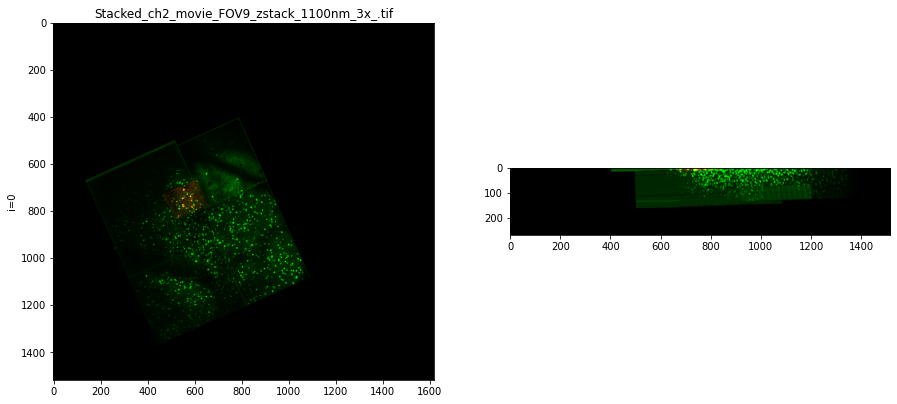

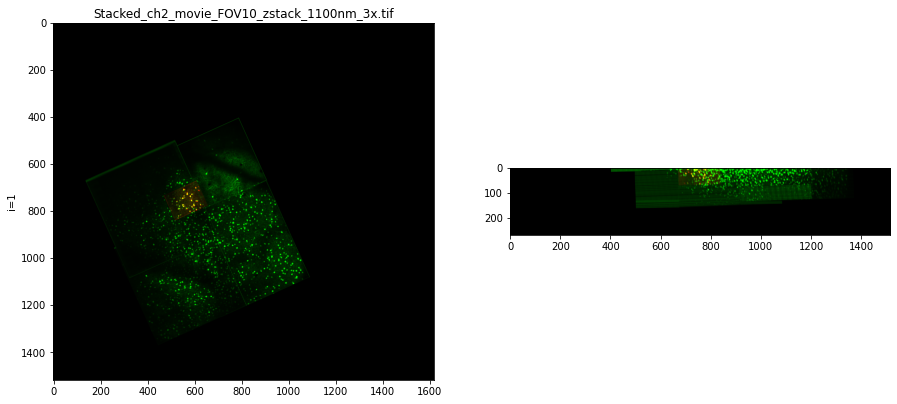

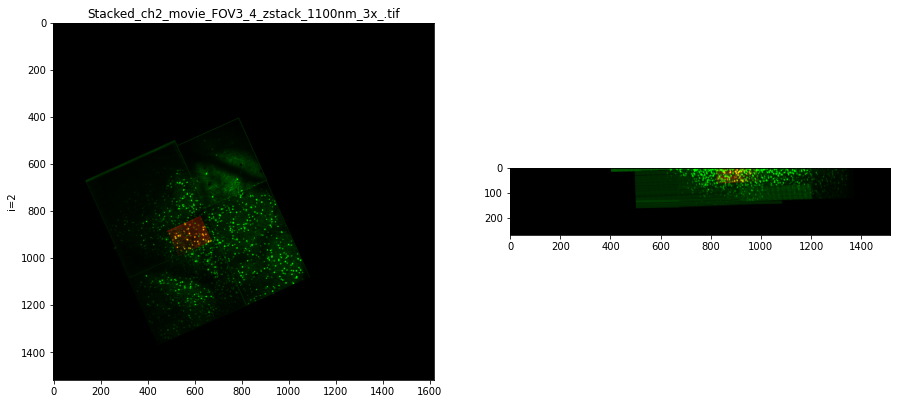

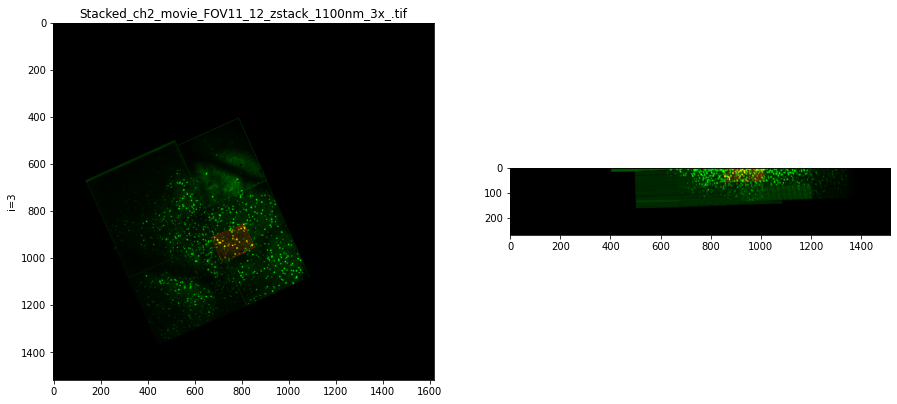

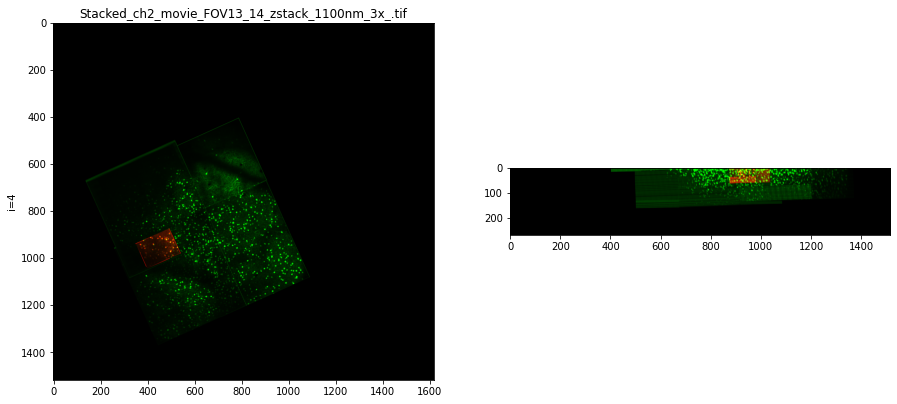

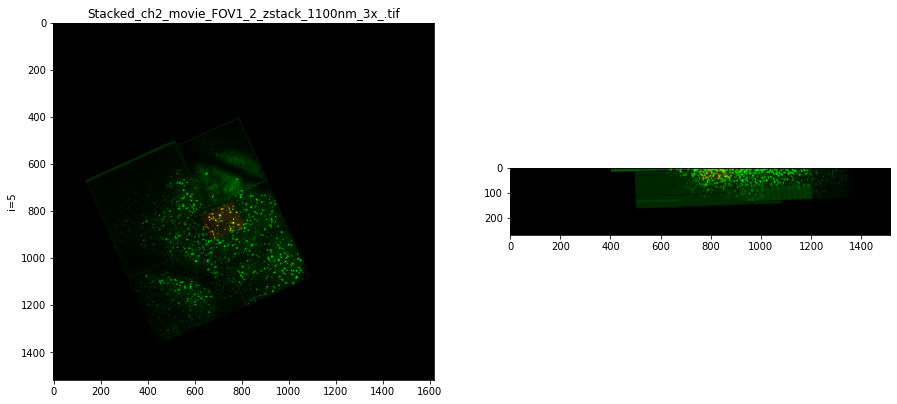

In [23]:
all_Ts=dict()
all_mapped=[]
c = 0
r = 10
radius = 200

plt.figure(figsize = (20,15))
plt.suptitle('2d phase correlation on the 2x downsampled data')
f_dir = os.listdir(f_dir_root_fov)[c]  # choose the channle 
filenames = [f.split('/')[-1] for f in glob.glob(f_dir_root_fov+'*.tif')]

resolution = np.array((1,0.631,0.625))  # these are um/pix
for i in range(len(filenames)):    
    print(f'loading file: `{filenames[i]}`')
    fov = tifffile.imread(f_dir_root_fov + filenames[i])  # chooose the FOV
    if filenames[i] in moreframefovs:
        print(filenames[i])
        fov = fov[np.arange(len(fov), step = 2)]    
    data = rescale(fov,resolution)
    data = ndi.zoom(data,1/2)    
    img2 = normalize(data)
    
    # learn the 2d rough registration 
    best_shift_original=learn_shift(img1,img2)
    img2_foo = pad2d(img2,img1.shape)
    img2_done = registration.roll_shift(img2_foo, best_shift_original)
    
    # crop at overlapping region 
    slicex = slice(best_shift_original[0]-r,best_shift_original[0]+img2.shape[0]+r)
    slicey = slice(best_shift_original[1]-r,best_shift_original[1]+img2.shape[1]+r)

    im1_clipped = img1[slicex,slicey]
    im2_clipped = img2_done[slicex,slicey]
    
    # polar-transformation
    im1_polar = warp_polar(im1_clipped, radius=radius)
    im2_polar = warp_polar(im2_clipped, radius=radius)    
    shifts, error, phasediff = phase_cross_correlation(im1_polar,im2_polar,upsample_factor=100,normalization=None)
    shiftr, shiftc = shifts[:2]
    shift_scale = 1 / (np.exp(shiftc / (radius / np.log(radius))))
    
    # apply the learned angle adn shift_Scale on 3d (note the change on the axis order!)
    R = get_R_from_a(-2*math.pi*shifts[0]/360)
    data_R = rescale(data,1/shift_scale)
    data_R = ndi.affine_transform(data_R.transpose(1,2,0), np.linalg.inv(R)).transpose(2,0,1)
    
    # re-learn the 2d shift on the rescaled, rotated iamge
    img2 = normalize(data_R)
    best_shift_new=learn_shift(img1,img2)
    img2_foo = pad2d(img2,img1.shape)
    img2_done = registration.roll_shift(img2_foo, best_shift_new)

    # create 3d volume in the small region
    zslice = slice(0,img2.shape[0])
    xslice = slice(best_shift_original[0]-r, best_shift_original[0] + img2.shape[0] + r)
    yslice = slice(best_shift_original[1]-r, best_shift_original[1] + img2.shape[1] + r)

    mini1 = invivo_tomato[:220,xslice,yslice]
    mini2 = np.zeros((data_R.shape[0],mini1.shape[1],mini1.shape[2])).astype(float)
    mini2[:,r:-r, r:-r] = data_R  # mini2 has to have a smaller shape!

    # learn 3d shift 
    best_shift_3d=learn_shift(mini1,mini2)
    mini2_foo = pad3d(mini2,mini1.shape)
    mini2_done = registration.roll_shift(mini2_foo, best_shift_3d)
    total_shift = best_shift_3d + np.array((0,best_shift_new[0],best_shift_new[1]))    
    
    # apply the entire thing!
    out = rescale(data,1/shift_scale)
    out = ndi.affine_transform(out.transpose(1,2,0), np.linalg.inv(R), output_shape=invivo_tomato.transpose(1,2,0).shape).transpose(2,0,1)
    out = registration.roll_shift(out, total_shift)
    
    data_t = trans(out[None], T_in_ex['transformations'], o_shape=o_shape)    
    all_mapped.append(data_t[0])
    
    plt.figure(figsize = (15,8))
    plt.subplot(1,2,1);plt.imshow(gray2RGB(all_mapped[-1],'r',scl=.2)+gray2RGB(invivo_tomato_t,'g',scl=.2))
    plt.title(filenames[i])
    plt.ylabel(f'i={i}')    
    plt.subplot(1,2,2);plt.imshow(gray2RGB(all_mapped[-1].transpose(2,0,1),'r',scl=.3)+gray2RGB(invivo_tomato_t.transpose(2,0,1),'g',scl=.2))

#     all_Ts[filenames[i]] = {'shift_scale':shift_scale,'R':R,'total_shift':total_shift}
    savefilepath = f'/home/ubuntu/largevolume2/massimo_xinxin/pkl/G130/transformed_results/transformed_FOVs/FOV_{filenames[i]}_mapped_to_exvivo_2xds.pkl'
    pickle.dump(data_t[0], open(savefilepath,'wb'))

